In [1]:
# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

In [6]:
import mediapy as media
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import mujoco as mujoco
DARM_XML_FILE = f"{os.getenv('DARM_MUJOCO_PATH')}/mujoco_env/darm.xml"
xml_path = DARM_XML_FILE

model = mujoco.MjModel.from_xml_path(xml_path)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

#### DARMEnv

In [3]:
import gym
from darm_gym_env import DARMEnv

env = gym.make("darm/DarmHand-v0", render_mode=None, hand_name="hand1",
               single_finger_env=False)
obs = env.reset()

Loaded XML file successfully


""

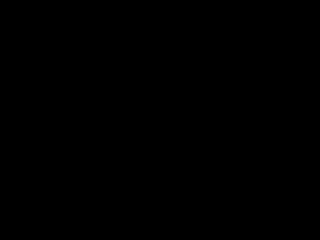

In [7]:
media.show_image(env.render())

#### End of DARMEnv

In [81]:
fingertip_obs[:, :3], self.target_obs[:, :3]import gym
import mujoco as mj
class MjModel(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 60}

    def __init__(self, render_mode=None, action_time=0.08, hand_name="hand1",
                min_th = 0.004,
                min_target_th = 2*0.004,
                max_target_th = 5*0.004, # 20 mm
                target_joint_state_delta = [],
                min_joint_vals = [],
                max_joint_vals = [],
                max_tendon_tension = [],
                single_finger_env = False,
                ignore_load_start_states = True,
                digits = ["ii"]
                ) -> None:
        super().__init__()
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        

        # ========================== Env Parameters ==========================
        self.render_mode = render_mode
        self.hand_name = hand_name
        self.single_finger_env = single_finger_env
        self.action_time = action_time
        self.ep_start_time = 0  # episode start time


        # ========================== Load the Model ==========================
        self._load_model()
        self.model = model
        self.data = data
        if not (self.model and self.data):
            raise "Error loading model"
        self._get_fingertip_indices()
        

        # ========================== Setup Rendering ==========================
        self.renderer = mj.Renderer(self.model)
        # enable joint visualization option:
        self.scene_option = mj.MjvOption()
        self.scene_option.flags[mj.mjtVisFlag.mjVIS_JOINT] = True
        self.last_frame = self.renderer.render()
        self.last_frame_time = 0


        # ========================== Load targets ==========================
        if not ignore_load_start_states:
            self._load_start_states()


        # ========================== Mujoco Model Simulation Parameters ==========================
        self.min_joint_vals = min_joint_vals or self._get_joint_limits("min")   # degrees
        self.max_joint_vals = max_joint_vals or self._get_joint_limits("max")   # degress
        # abs increament of joint state from starting state to target state
        self.target_joint_state_delta = target_joint_state_delta or self._compute_target_joint_state_delta()   # degrees
        self.max_tendon_tension = max_tendon_tension or self._get_actuator_ctrlrange("max")

        self.min_joint_vals = self.min_joint_vals*(np.pi/180)
        self.max_joint_vals = self.max_joint_vals*(np.pi/180)
        self.target_joint_state_delta = self.target_joint_state_delta*(np.pi/180)

        self.min_th = min_th    # norm threshold in metres at which env is solved
        self.min_target_th = min_target_th  # min norm to target state
        self.max_target_th = max_target_th  # max norm to target state

        # Initialize target observation
        self.target_obs = np.zeros((5,7))
        self.prev_fingertip_pose = np.zeros((5,7))
        


        # ========================== Reward Components Weights ==========================
        self.rwd_keys_wt = dict(
            reach = 1.0,
            bonus = 4.0,
            penalty = 50,
            act_reg = 0.01,
            # sparse = 1,
            # solved = 1, # review - weight should not be assigned to this?
            # done = 1 # review - weight should not be assigned to this?
        )


        # ========================== Get Ref Position ==========================
        # Reference Position is at the centre of the wrist
        # The ref pos will remain fixed since it was taken before simulation started
        mj.mj_forward(self.model, self.data)
        ref_body_idx = mj.mj_name2id(self.model, int(mj.mjtObj.mjOBJ_BODY), f"{self.hand_name}_rc_centre_block")
        self.ref_pos = np.array(self.data.xpos[ref_body_idx])


        # ========================== Define Observation and Action Space ==========================
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, 
                                                shape=(3*3*len(self.fingertip_indices),), 
                                                dtype=np.float32)
        

        # NOTE: Watch out for Box upper limit if Carpal Actuators are involved
        # FIXME: Fix action range in reward and step functions. Current ==> [0,2] after denorm
        # Define a mujoco action range array used for scaling
        self.action_space = gym.spaces.Box(low=np.array([-1.0]*self.model.nu), 
                                            high=np.array([1.0]*self.model.nu), 
                                            shape=(self.model.nu,), dtype=np.float32)


        # ========================== For Human Rendering ==========================
        self.window = None
        self.window_size = 1200, 900

        # ========================== Others ==========================
        self.index_str_mapping = {"i":0, "ii":1, "iii":2, "iv":3, "v":4}
        self.index_int_mapping = {0:"i", 1:"ii", 2:"iii", 3:"iv", 4:"v"}
        self.digits = digits

    def _load_model(self):
        xml_path = DARM_XML_FILE
        self.model = mj.MjModel.from_xml_path(xml_path)

        if self.model: 
            print("Loaded XML file successfully") 
        else:
            print(f"Error Loading XML file: {xml_path}")
            return
        
        self.data = mj.MjData(self.model)
        renderer = mj.Renderer(self.model)

    def _load_start_states(self):
        if self.single_finger_env:
            filename = SF_START_STATE_FILE
        else:
            filename = MF_START_STATE_FILE

        with open(filename, 'rb') as f:
            self.start_states = np.load(f, allow_pickle=True)
            self.start_states_len = len(self.start_states)

    def _get_joint_limits(self, type = None):
        joint_limits = []
        for i in range(self.model.njnt):
            joint_limits.append(self.model.jnt_range[i]*(180/np.pi))
        
        joint_limits = np.asarray(joint_limits)
        
        if type == "min":
            return joint_limits[:, 0]
        if type == "max":
            return joint_limits[:, 1]
        
        return joint_limits[:, 0], joint_limits[:, 1]

    def _compute_target_joint_state_delta(self):
        # return (self.max_joint_vals - self.min_joint_vals)//10  # for every range of 10 deg, have a delta of 1 deg
        joint_state_delta =  ((self.max_joint_vals - self.min_joint_vals)//40) * 2  # for every range of 40 deg, have a delta of 2 deg
        return np.clip(joint_state_delta, a_min=2, a_max=10)    # a minimum delta of 2 degrees, max of 10 degrees

    def _get_actuator_ctrlrange(self, type = None):
        if type == "min":
            return np.array([self.model.actuator_ctrlrange[i][0] for i in range(self.model.nu)])
        if type == "max":
            return np.array([self.model.actuator_ctrlrange[i][1] for i in range(self.model.nu)])
    
        ctrl_range = np.array([self.model.actuator_ctrlrange[i] for i in range(self.model.nu)])
        return ctrl_range[:, 0], ctrl_range[:, 1] # (min, max)

    def _init_controller(self):
        pass

    def _controller_cb(self, model, data):
        pass

    def _get_fingertip_indices(self):
        # NOTE: Remember to set the mocap index properly in reset()
        if self.single_finger_env:
            indices = ["ii"]
        else:
            indices = ["i", "ii", "iii", "iv", "v"]

        self.fingertip_indices = [mj.mj_name2id(self.model, int(mj.mjtObj.mjOBJ_SITE), f"{self.hand_name}_fingertip_{i}") for i in indices]
    
    def transform_distance_obs(self, obs):
        """
        - Transforms the distance to be in the frame of the wrist (RC Joint)
        - Convert the distance reading to cm
        """
        return (obs - self.data.body(f"{self.hand_name}_rc_centre_block").xpos)*100

    def get_finger_frames_pos(self, idx_str):
        # get Proximal Phalanx frame
        def pp_frame():
            # BODY: ${hand_name}_proximal_phalanx_${index}
            frame_pos = self.data.body(f"{self.hand_name}_proximal_phalanx_{idx_str}").xpos
            return self.transform_distance_obs(frame_pos)
            
        # get Middle Phalanx frame
        def mp_frame():
            # BODY: ${hand_name}_middle_phalanx_${index} [ii to v]
            frame_pos = self.data.body(f"{self.hand_name}_middle_phalanx_{idx_str}").xpos
            return self.transform_distance_obs(frame_pos)

        # get Distal Phalanx frame
        def dp_frame():
            # BODY: ${hand_name}_distal_phalanx_${index}
            frame_pos = self.data.body(f"{self.hand_name}_distal_phalanx_{idx_str}").xpos
            return self.transform_distance_obs(frame_pos)

        # get fingertip frame
        def fingertip_frame():
            # SITE: ${hand_name}_fingertip_${index}
            frame_pos = self.data.site(f"{self.hand_name}_fingertip_{idx_str}").xpos
            return self.transform_distance_obs(frame_pos)

        if idx_str == "i":
            return np.concatenate((pp_frame(), dp_frame(),
                                   fingertip_frame()))
        else:
            return np.concatenate((pp_frame(), mp_frame(),
                                   dp_frame(), fingertip_frame()))

    def get_fingertip_pose(self, idx_str):
        """Returns the position and orientation of the fingertip `idx_str`"""

        fingertip_pos = self.data.site(f"{self.hand_name}_fingertip_{idx_str}").xpos
        fingertip_pos = self.transform_distance_obs(fingertip_pos)

        fingertip_orient = self.data.body(f"{self.hand_name}_distal_phalanx_{idx_str}").xquat

        return np.concatenate((fingertip_pos, fingertip_orient))        

    def get_finger_contacts(self, index):
        contact_geoms1 = self.data.contact.geom1
        contact_geoms2 = self.data.contact.geom2

        colliding_digits = []
        colliding_with_palm = False

        def get_digit_str(name):
            if name.endswith("_i"): return "i"
            if name.endswith("_ii"): return "ii"
            if name.endswith("_iii"): return "iii"
            if name.endswith("_iv"): return "iv"
            if name.endswith("_v"): return "v"
            
            return None

        def filter_contacts(contacts1, contacts2):
            for idx in range(len(contacts1)):
                geom_idx = contacts1[idx]
                # Ignore Wraps
                if "_wrap" in self.model.geom(geom_idx).name:
                    continue
                
                # Get the Body name
                bodyid = self.model.geom(geom_idx).bodyid[0]
                bodyname = self.model.body(bodyid).name

                # If body is in current phalanges group
                if bodyname.endswith(f"_phalanx_{self.index_int_mapping[index]}"):
                    coll_geom_idx = contacts2[idx]
                    # Ignore Wraps
                    if "_wrap" in self.model.geom(coll_geom_idx).name:
                        continue

                    # Get the body collided with
                    coll_bodyid = self.model.geom(coll_geom_idx).bodyid[0]
                    coll_bodyname = self.model.body(coll_bodyid).name

                    if coll_bodyname == "hand1_carpals_metacarpals":
                        nonlocal colliding_with_palm
                        colliding_with_palm = True

                    digit = get_digit_str(coll_bodyname)
                    if digit and (digit != self.index_int_mapping[index]):
                        colliding_digits.append(digit)

        filter_contacts(contact_geoms1, contact_geoms2)
        filter_contacts(contact_geoms2, contact_geoms1)

        collision_obs = np.zeros(6)
        if colliding_with_palm: collision_obs[0] = 1
        for idx_str in colliding_digits:
            collision_obs[self.index_str_mapping[idx_str]+1] = 1

        return collision_obs

    def digits_in_contact(self):
        indices = [self.index_str_mapping[i] for i in ["i", "ii", "iii", "iv", "v"]]
        contacts = np.concatenate([self.get_finger_contacts(index) for index in indices])
        return sum(contacts) > 0

    def get_obs(self, action_time=None):
        def get_target_pose(index):
            return self.target_obs[index]

        def get_kinematic_chain_obs(index):
            return self.get_finger_frames_pos(self.index_int_mapping[index])

        def get_vel_obs(index):
            if not action_time:
                # if no action time, velocity is zero. i.e. after reset
                return np.zeros(3)
            
            prev_fingertip_pos = self.prev_fingertip_pose[index][:3]
            new_fingertip_pos = self.get_fingertip_pose(self.index_int_mapping[index])[:3]
            vel_obs = (new_fingertip_pos - prev_fingertip_pos)/action_time
            return vel_obs

        def get_contact_obs(index):
            return self.get_finger_contacts(index)

        def get_finger_obs(index):
            return np.concatenate((get_target_pose(index),
                            get_kinematic_chain_obs(index),
                            get_vel_obs(index),
                            get_contact_obs(index)))
            
        indices = [self.index_str_mapping[i] for i in self.digits]
        obs = np.concatenate([get_finger_obs(index) for index in indices])
        return obs

    def _get_info(self):
        return {"sim_time": self.data.time - self.ep_start_time}

    def _norm_to_target(self, obs):
        """
        Returns the norm of each fingertip to the target position
        obs: an observation from the observation space [...fingertip_pos, ...target_pos, ...fingertip_vel]
        """
        obs = obs.reshape((-1, 3))
        n_fingertips = len(self.fingertip_indices)

        fingertip_poses = obs[0:n_fingertips]
        target_poses = obs[n_fingertips:2*n_fingertips]

        return np.linalg.norm(fingertip_poses-target_poses, ord=2, axis=-1)

    def _get_reward(self, action, new_state):
        """
        Reward function to compute reward given action, and new state.
        R = R(a, S')

        Agent is punished for being far from target
        Agent is punished for going farther than a threshold from the target
        Agent is punished for high action magnitude
        Agent is rewarded for being close to the target
        Agent is rewarded for coming close to the target beyond a threshold 
        """

        reach_dist = self._norm_to_target(new_state)    # NOTE: Single finger
        near_th = self.min_th
        far_th = 2*self.max_target_th

        # Scale action down to [0, 1] from [0, max_tendon_tension]
        action = action / self.max_tendon_tension
        
        # NOTE: Some of the fingers in five fingered hand have more than five actuators
        # act_mag = np.linalg.norm(action.reshape(-1, 5)) # reshape action to (-1,5), ensure nu is ordered from mujoco
        # TODO: Consider scaling down this act_mag to be equiv. to a single finger with nu=5
        act_mag = np.linalg.norm(action)/np.sqrt(self.model.nu/1) # action magnitude is not measured per finger but as a whole
        act_mag = np.array([act_mag]*len(self.fingertip_indices))
        # by dividing by sqrt(nu/5), the norm is similar to when computing with nu==5. Check it out.
        # by dividing by sqrt(nu) act_mag will have a max value in the order of the max_value of action now => 1
        
        rwd_dict = collections.OrderedDict((
            # Optional Keys
            ('reach',   -1.*reach_dist),
            ('bonus',   1.*(reach_dist<2*near_th) + 1.*(reach_dist<near_th)),
            ('act_reg', -1.*act_mag),
            ('penalty', -1.*(reach_dist>far_th)),
            # Must keys
            ('sparse',  -1.*reach_dist),
            ('solved',  reach_dist<near_th),
            ('done',    reach_dist > far_th),
        ))

            # Weights:
            # reach = 1.0,
            # bonus = 4.0,
            # penalty = 50,
            # act_reg = 0.1,
        rwd_dict['dense'] = np.sum([wt*rwd_dict[key] for key, wt in self.rwd_keys_wt.items()], axis=0)
        return rwd_dict

    def _get_done(self, new_state):
        return all(self._norm_to_target(new_state) < self.min_th)

    def _check_collision(self):
        """Returns True if there is collision, otherwise False"""
        return len(self.data.contact.geom1) > 0

    def generate_start_state(self):
        while True:
            # ========================== Sample valid start_state from Joint Space ==========================
            joint_state = np.random.uniform(low=self.min_joint_vals, high=self.max_joint_vals)
            # normal_sampling = np.random.normal(loc=0.5, scale=0.5/3, size=self.min_joint_vals.shape)
            # normal_sampling = np.clip(normal_sampling, 0, 1)
            # joint_state = self.min_joint_vals + normal_sampling*(self.max_joint_vals - self.min_joint_vals)
            self.forward(joint_state)

            if self._check_collision(): # returns True if there is collision
                # ensure there is no collision at the start state
                continue
            
        
            # ========================== Create a valid target ==========================
            joint_state_delta = self.target_joint_state_delta*np.random.choice(a=[-1,1], size=(self.model.njnt,), replace=True)
            target_joint_state = np.clip(a=joint_state + joint_state_delta, 
                                        a_min=self.min_joint_vals, 
                                        a_max=self.max_joint_vals)
            self.target_obs = self.forward(target_joint_state)[:3*len(self.fingertip_indices)]
            if self._check_collision(): # returns True if there is collision
                # ensure there is no collision at the target state
                continue
            
            # Return to start state
            observation = self.forward(joint_state)

            # Verify distance of start state to target state is within limits
            norm = self._norm_to_target(observation)
            if not (all(norm >= self.min_target_th) and all(norm <= self.max_target_th)):
                continue
            
            # If all checks are positive, break random search loop
            return observation, joint_state, self.target_obs      

    def sample_saved_start_states(self):
        # Sample a start state from saved start states
        # start_state = [joint_state, target_obs]
        start_state = self.start_states[np.random.randint(self.start_states_len)]

        # Set Target Obs
        self.target_obs = start_state[1]

        # Go forward to start state
        observation = self.forward(start_state[0])

        # Return Observation
        return observation

    def reset(self, **kwargs):
        # ========================== Get a random valid pose and target ==========================
        # observation, _, _ = self.generate_start_state()
        observation = self.sample_saved_start_states()

        # ========================== Render Frame ==========================
        if self.render_mode == "human":
            # Update target visualization mocaps pos
            self.data.mocap_pos = self.target_obs.reshape(len(self.fingertip_indices),3) + self.ref_pos
            # Go Forward
            mj.mj_forward(self.model, self.data)
            self._render_frame()

        self.ep_start_time = self.data.time
        return observation

    def step(self, action):
        prev_obs = self._get_obs(prev_obs=None, new_obs=None, action_time=None)

        # action from model is in the range [-1,1]
        # action + 1 === [0, 2]
        # action * x === [0, 2x]
        action = (action + 1)*(self.max_tendon_tension/2)
        action = np.clip(action, 0, self.max_tendon_tension)
        self.data.ctrl[0 : self.model.nu] = action
        time_prev = self.data.time   # simulation time in seconds

        # Perform action  
        while (self.data.time - time_prev < self.action_time):
            mj.mj_step(self.model, self.data)
        time_after = self.data.time # time after performing action


        # Get new observation (fingertips_pos)
        new_obs = self._get_obs(prev_obs=None, new_obs=None, action_time=None)
        # include velocity in new obs
        new_obs = self._get_obs(prev_obs=prev_obs,
                                new_obs=new_obs, 
                                action_time=time_after-time_prev)

        if self.render_mode == "human":
            self._render_frame()

        # Get Reward
        rwd_dict = self._get_reward(action, new_obs)
        reward = rwd_dict["dense"].mean()
        done = any(rwd_dict["done"])  # all(rwd_dict["done"])
        
        return new_obs, reward, done, {**self._get_info(), "action": action, "reward": {**rwd_dict}}

    def forward(self, joint_conf):
        self.data.qpos = joint_conf
        mj.mj_forward(self.model, self.data)
        return self._get_obs(prev_obs=None, new_obs=None, action_time=None)

    def render(self, mode, **kwargs):
        if self.render_mode == "human":
            return self._render_frame()
        else:
            T = 1/DARMEnv.metadata["render_fps"]    # period
            if (self.data.time - self.last_frame_time) >= T:
                self.renderer.update_scene(self.data, scene_option=self.scene_option)
                self.last_frame = self.renderer.render()
            return self.last_frame.copy()

    def _render_frame(self):
        if self.render_mode == "human" and not self.window:
            # Init GLFW, create window, make OpenGL context current, request v-sync
            glfw.init()
            self.window = glfw.create_window(self.window_size[0], self.window_size[1], "DARM", None, None)
            glfw.make_context_current(self.window)
            glfw.swap_interval(1)

            # Visualization
            self.cam = mj.MjvCamera()    # abstract camera
            self.opt = mj.MjvOption()    # visualization options
            mj.mjv_defaultCamera(self.cam)
            mj.mjv_defaultOption(self.opt)
            self.scene = mj.MjvScene(self.model, maxgeom=10000)
            self.context = mj.MjrContext(self.model, mj.mjtFontScale.mjFONTSCALE_150.value)

            self.cam.azimuth = 110
            self.cam.elevation = -24
            self.cam.distance = 0.36
            self.cam.lookat = np.array([0.006, -0.004,  0.215])

            # For callback functions TODO:
            self.window_button_left = False
            self.window_button_middle = False
            self.window_button_right = False
            self.window_lastx = 0
            self.window_lasty = 0

            def mouse_button(window, button, act, mods):
                # update button state
                self.window_button_left = (glfw.get_mouse_button(
                    window, glfw.MOUSE_BUTTON_LEFT) == glfw.PRESS)
                self.window_button_middle = (glfw.get_mouse_button(
                    window, glfw.MOUSE_BUTTON_MIDDLE) == glfw.PRESS)
                self.window_button_right = (glfw.get_mouse_button(
                    window, glfw.MOUSE_BUTTON_RIGHT) == glfw.PRESS)

                # update mouse position
                glfw.get_cursor_pos(window) # TODO: Why is this needed again

            def mouse_move(window, xpos, ypos):
                # compute mouse displacement, save
                dx = xpos - self.window_lastx
                dy = ypos - self.window_lasty
                self.window_lastx = xpos
                self.window_lasty = ypos

                # no buttons down: nothing to do
                if (not self.window_button_left) and (not self.window_button_middle) and (not self.window_button_right):
                    return

                # get current window size
                width, height = glfw.get_window_size(window)

                # get shift key state
                PRESS_LEFT_SHIFT = glfw.get_key(
                    window, glfw.KEY_LEFT_SHIFT) == glfw.PRESS
                PRESS_RIGHT_SHIFT = glfw.get_key(
                    window, glfw.KEY_RIGHT_SHIFT) == glfw.PRESS
                mod_shift = (PRESS_LEFT_SHIFT or PRESS_RIGHT_SHIFT)

                # determine action based on mouse button
                if self.window_button_right:
                    if mod_shift:
                        action = mj.mjtMouse.mjMOUSE_MOVE_H
                    else:
                        action = mj.mjtMouse.mjMOUSE_MOVE_V
                elif self.window_button_left:
                    if mod_shift:
                        action = mj.mjtMouse.mjMOUSE_ROTATE_H
                    else:
                        action = mj.mjtMouse.mjMOUSE_ROTATE_V
                else:
                    action = mj.mjtMouse.mjMOUSE_ZOOM

                mj.mjv_moveCamera(self.model, action, dx/width,
                                dy/height, self.scene, self.cam)    # TODO: Look into this, height/width issue

            def scroll(window, xoffset, yoffset):
                action = mj.mjtMouse.mjMOUSE_ZOOM
                mj.mjv_moveCamera(self.model, action, 0.0, -0.05 *
                                yoffset, self.scene, self.cam)

            glfw.set_cursor_pos_callback(self.window, mouse_move)
            glfw.set_mouse_button_callback(self.window, mouse_button)
            glfw.set_scroll_callback(self.window, scroll)
        
        # Get Framebuffer Viewport
        vp_width, vp_height = glfw.get_framebuffer_size(self.window)
        viewport = mj.MjrRect(0, 0, vp_width, vp_height)

        # Update scene and render
        mj.mjv_updateScene(self.model, self.data, self.opt, None, self.cam, mj.mjtCatBit.mjCAT_ALL.value, self.scene)
        mj.mjr_render(viewport, self.scene, self.context)

        # swap OpenGL buffers (blocking call due to v-sync)
        glfw.swap_buffers(self.window)

        # process pending GUI events, call GLFW callbacks
        glfw.poll_events()

    def close(self):
        glfw.terminate()

""

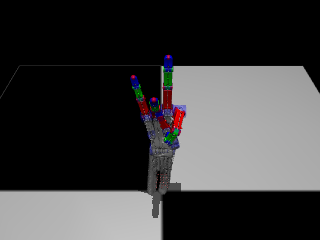

In [76]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [84]:
model_cl = MjModel()
model_cl.get_finger_contacts(0)

Loaded XML file successfully


array([1., 0., 1., 0., 1., 0.])

In [85]:
model_cl.digits_in_contact()

True

In [74]:
len(model_cl.get_obs(0.08)), model_cl.get_obs(0.08)

(28,
 array([  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   2.93      ,
          0.87      ,   9.08      ,   3.35532002,   0.87      ,
         13.94143013,   3.58889742,   0.87      ,  16.61123192,
          3.77279603,   0.87      ,  18.71320273,  47.1599504 ,
         10.875     , 233.91503413,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]))

In [68]:
data.contact.geom1, data.contact.geom2

(array([12, 45], dtype=int32), array([47, 26], dtype=int32))

In [49]:
data.body(47)

<_MjDataGeomViews
  id: 47
  name: ''
  xmat: array([-0.08988067, -0.97442545, -0.20595267,  0.99594543, -0.08715574,
       -0.02228407,  0.00376421, -0.20712052,  0.97830819])
  xpos: array([-0.03139738,  0.00431935,  0.25504528])
>

In [77]:
for i in range(32):
    print(model.body(i).name or "NO NAME")

world
hand1_fingertip_i_target
hand1_fingertip_ii_target
hand1_fingertip_iii_target
hand1_fingertip_iv_target
hand1_fingertip_v_target
hand1_forearm
hand1_rc_centre_block
hand1_carpals_metacarpals
hand1_mcp_centre_block_ii
hand1_proximal_phalanx_ii
hand1_middle_phalanx_ii
hand1_distal_phalanx_ii
hand1_mcp_centre_block_iii
hand1_proximal_phalanx_iii
hand1_middle_phalanx_iii
hand1_distal_phalanx_iii
hand1_mcp_centre_block_iv
hand1_proximal_phalanx_iv
hand1_middle_phalanx_iv
hand1_distal_phalanx_iv
hand1_proximal_cm_i_centre_block
hand1_distal_cm_i_centre_block
hand1_metacarpal_i
hand1_proximal_phalanx_i
hand1_distal_phalanx_i
hand1_proximal_cm_v_centre_block
hand1_distal_cm_v_centre_block
hand1_metacarpal_v
hand1_mcp_centre_block_v
hand1_proximal_phalanx_v
hand1_middle_phalanx_v


In [15]:
sn = 0
for idx in data.contact.geom1: #range(53):
    print(sn, model.body(model.geom(idx).bodyid[0]).name, model.geom(idx).name or "NO_NAME")
    sn += 1

0 hand1_carpals_metacarpals NO_NAME
1 hand1_carpals_metacarpals hand1_mcp_iv_wrap
2 hand1_distal_phalanx_ii NO_NAME
3 hand1_metacarpal_i hand1_mcp_i_wrap
4 hand1_distal_phalanx_ii NO_NAME
5 hand1_proximal_phalanx_iv NO_NAME
6 hand1_proximal_phalanx_i hand1_ip_i_wrap
7 hand1_proximal_phalanx_iv NO_NAME
8 hand1_metacarpal_v hand1_mcp_v_wrap
9 hand1_middle_phalanx_iv NO_NAME
10 hand1_middle_phalanx_iv hand1_pip_iv_wrap


In [16]:
sn = 0
for idx in data.contact.geom2: #range(53):
    print(sn, model.body(model.geom(idx).bodyid[0]).name, model.geom(idx).name or "NO_NAME")
    sn += 1

0 hand1_proximal_phalanx_i NO_NAME
1 hand1_proximal_phalanx_v NO_NAME
2 hand1_metacarpal_i NO_NAME
3 hand1_distal_phalanx_ii NO_NAME
4 hand1_proximal_phalanx_i NO_NAME
5 hand1_proximal_phalanx_i NO_NAME
6 hand1_proximal_phalanx_iv NO_NAME
7 hand1_distal_phalanx_i NO_NAME
8 hand1_proximal_phalanx_iv NO_NAME
9 hand1_distal_phalanx_i NO_NAME
10 hand1_distal_phalanx_i NO_NAME


In [75]:
data.joint(11).qpos = 0.605 # np.radians(60)
data.joint(16).qpos = -0.349 # np.radians(60)

data.joint(2).qpos = 0.349
data.joint(3).qpos = 1.57
data.joint(4).qpos = 1.57
data.joint(5).qpos = 1.57

In [24]:
data.body(f"hand1_distal_phalanx_ii").xquat, data.body(f"hand1_middle_phalanx_ii").xquat

(array([ 0.92094275,  0.37735207,  0.0068244 , -0.09707367]),
 array([ 0.99524654, -0.00380168,  0.0434534 , -0.08707279]))

In [25]:
data.body(f"hand1_distal_phalanx_ii").xquat - data.body(f"hand1_middle_phalanx_ii").xquat

array([-0.07430379,  0.38115375, -0.03662901, -0.01000088])

In [39]:
dp = data.body(f"hand1_distal_phalanx_ii").xquat
mp = data.body(f"hand1_middle_phalanx_ii").xquat
np.degrees(2*np.arccos(np.abs(np.dot(dp, mp))))

59.999999999999986

In [11]:
import numpy as np

quat1 = [[ 0.92094275,  0.37735207,  0.0068244 , -0.09707367], 
         [ 0.92094275,  0.37735207,  0.0068244 , -0.09707367]]

quat2 = [[ 0.99524654, -0.00380168,  0.0434534 , -0.08707279],
        [ 0.99524654, -0.00380168,  0.0434534 , -0.08707279]]

# quat1 = [ 0.92094275,  0.37735207,  0.0068244 , -0.09707367]
# quat2 = [ 0.99524654, -0.00380168,  0.0434534 , -0.08707279]

In [21]:
np.degrees(2*np.arccos(np.abs(np.dot(quat1, np.transpose(quat2)).diagonal())))
# np.arccos(np.abs(np.dot(quat1, np.transpose(quat2)).diagonal()))

array([45.00000006, 45.00000006])

In [11]:
type(data.site("hand1_fingertip_i").xpos)

numpy.ndarray

In [1]:
import gym
from darm_gym_env import DARMEnv

In [2]:
env = gym.make("darm/DarmHand-v0", render_mode=None, hand_name="hand1",
               single_finger_env=True)

Loaded XML file successfully


/opt/conda/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [3]:
import numpy as np

done = False
frames = []

env.reset()
while not done:
    _, _, done, _ = env.step(env.action_space.sample())
    frame = env.render()
    
    if len(frames) == 0 or (not np.array_equal(frame, frames[-1])):
        frames.append(frame)

env.close()

In [4]:
len(frames)

5

In [16]:
import time
from IPython.display import display
from IPython.display import clear_output

for i in range(len(frames)):
    media.show_image(frames[i])
    time.sleep(1)
    clear_output()

In [11]:
!conda install -c conda-forge ffmpeg -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.11.1
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.1.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - ffmpeg


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.12.7  |       ha878542_0         143 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    conda-23.1.0               |  py310hff52083_0         918 KB  conda-forge
    openssl-1.1.1t             |       h7f8727e_0         3.7 MB
    python_abi-3.10            |          2_cp310           4 KB  conda-forge
    ------------------------------------------------------------
   

In [12]:
media.show_video(frames, fps=60)

RuntimeError: Error writing '/tmp/tmpl9eo_73w/file.mp4': Unrecognized option 'qp'.
Error splitting the argument list: Option not found
